# Image Fusion

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
def crop_image_to_mask(img, box):
    new_img = img[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    
    return new_img

In [22]:
# cv2 resize to keep aspect ratio
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [48]:
def bounding_box_s(img, save_path='',show_binary=False, 
                 can1=10, can2=150, can3=1, 
                 dilate0=0, erode1=0, 
                 dilate1=0, erode2=0, 
                 dilate2=0, choose=0):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray_img, 90, 255,cv2.THRESH_BINARY)
    #binary = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11,25)
    edges = cv2.Canny(img, can1, can2, can3)
    bin_edge = cv2.add(binary, edges)
    edge_0 = cv2.dilate(bin_edge, np.ones((3,3)), iterations=dilate0)
    edge_1 = cv2.erode(edge_0, np.ones((3,3)), iterations=erode1)
    edge_2 = cv2.dilate(edge_1, np.ones((3,3)), iterations=dilate1)
    edge_3 = cv2.erode(edge_2, np.ones((3,3)), iterations=erode2)
    edge_4 = cv2.dilate(edge_3, np.ones((3,3)), iterations=dilate2)
    img_list = [gray_img, binary, edges, bin_edge, edge_0, edge_1, edge_2, edge_3, edge_4] 

    if show_binary:
        cv2.imshow("Binary", binary)
        cv2.imshow("Edge", edges)
        cv2.imshow("Bin+Edge:", bin_edge)
        cv2.imshow('dilate0', edge_0)
        cv2.imshow('errode1', edge_1)
        cv2.imshow('dilate1', edge_2)
        cv2.imshow('errode2', edge_3)
        cv2.imshow('dilate2', edge_4)
    
    _, cnts, _=cv2.findContours(edge_4, 1,2)
    box_list = []
    if len(cnts) > 0:
        for cnt in cnts:        
            x,y,w,h = cv2.boundingRect(cnt)
            box_list.append((x,y,w,h))

    return box_list, img_list

In [57]:
def image_fusion(image_path, bg_img_path,position_top_left=(10,10),bg_resize=False,
                 save_img="" ,log_enable=False):
    '''return fusion image and bounding box (xmin, ymin, xmax, ymax)'''
    f = cv2.imread(image_path)
    f0 = f.copy()
    boxs, mask = bounding_box_s(f0, save_path='', show_binary=False,
                     can1=250, can2=255, can3=1, 
                     dilate0=10, erode1=10, 
                     dilate1=0, erode2=0, 
                     dilate2=0, choose=0)
    box0 = (0,0,0,0)
    if len(boxs):
        if log_enable:
            print("found boxs:", boxs)
        for idx ,box in enumerate(boxs):
            if box[2] <80 or box[3]<80:
                continue
            elif box[3] > 350 and box[2]*box[3] > 50000:
                continue
            elif box[1] < 5 or box[0] > 600:
                continue
            else:
                box0 = box
                result = crop_image_to_mask(mask[-1], box)
                img_crop = crop_image_to_mask(f0, box)
                img_object = img_crop.copy()
                img_bk_ground = img_crop.copy()
                #mask image
                img_object[result==0] =(0,0,0)
                img_bk_ground[result!=0] =(255,0,0)
            if log_enable:
                #plot
                print(box)
                plt.figure(figsize=[15,10])
                plt.subplot(1,4,1)
                plt.imshow(result, cmap='gray')
                plt.xticks([]), plt.yticks([])
                plt.title('mask')
                plt.subplot(1,4,2)
                plt.imshow(img_crop)
                plt.xticks([]), plt.yticks([])
                plt.title('corp_image')
                plt.subplot(1,4,3)
                plt.imshow(img_object)
                plt.xticks([]), plt.yticks([])
                plt.title('mask show original object\n and make background black')
                plt.subplot(1,4,4)
                plt.imshow(img_bk_ground)
                plt.xticks([]), plt.yticks([])
                plt.title('mask show original background\n and make object red')
    else:
        print('no box found')
    #handling background
    back_ground_image_0 = cv2.imread(bg_img_path)
    if bg_resize:
        print('background_resize to 640*480')
        back_ground_image = image_resize(back_ground_image_0, 640, 480)
    else:
        back_ground_image = back_ground_image_0
    if log_enable:
        plt.figure()
        plt.imshow(back_ground_image), plt.xticks([]), plt.yticks([]); 
        plt.title('BackGround')
    bg_mask = np.zeros((back_ground_image.shape[0], back_ground_image.shape[1]), dtype='uint8')
    box0_size = (box0[2]//2, box0[3]//2)
    print('object_crop_img_size:', box0[2], box0[3])
    
    #record bounding box position /width/ height
    bounding_box = (position_top_left[0],position_top_left[1], position_top_left[0]+box0[2], position_top_left[1]+box0[3])
    bg_mask[position_top_left[1]:position_top_left[1]+result.shape[0],position_top_left[0]:position_top_left[0]+result.shape[1]] = result
    if log_enable:
        plt.figure()
        plt.imshow(bg_mask, cmap='gray'), plt.xticks([]), plt.yticks([]);
        plt.title('object_bg_mask')
    #handle background with mask
    bg_1 = back_ground_image.copy()
    bg_1[bg_mask==255] = (0,0,0)
    if log_enable:
        plt.figure(), plt.title('hollow object background')
        plt.imshow(bg_1, cmap='gray'), plt.xticks([]), plt.yticks([]);
    # handle object on backgoround
    object_mask = np.zeros_like(back_ground_image)
    object_mask[position_top_left[1]:position_top_left[1]+result.shape[0],
                position_top_left[0]:position_top_left[0]+result.shape[1]] = img_object
    
    if log_enable:
        plt.figure(), plt.title('object only')
        plt.imshow(object_mask, cmap='gray'), plt.xticks([]), plt.yticks([]);
    final = cv2.add(bg_1, object_mask)
    if log_enable:
        plt.figure(), plt.title('Final Fusion'), plt.xticks([]), plt.yticks([]);
        plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB));
    if save_img != "":
        cv2.imwrite(save, final)
        print("save img:", save_img)
    return final, bounding_box
    

found boxs: [(396, 325, 1, 1), (242, 154, 155, 172)]
(242, 154, 155, 172)
background_resize to 640*480
object_crop_img_size: 155 172
fusion img bounding box: (280, 190, 435, 362)


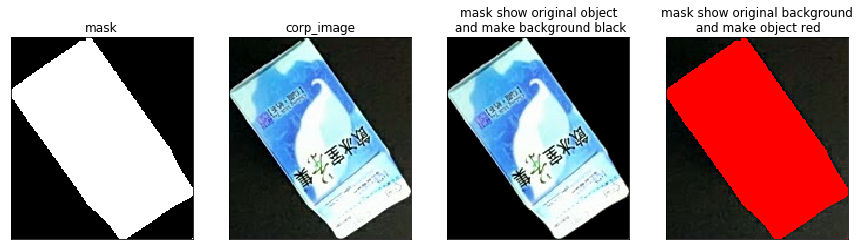

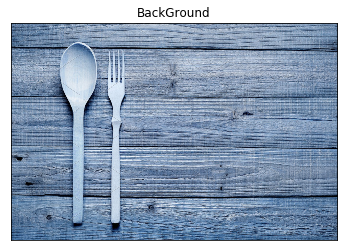

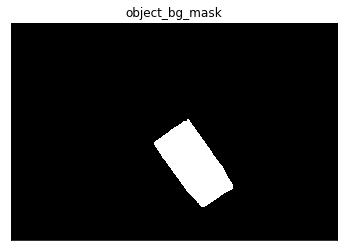

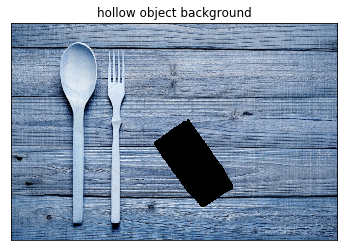

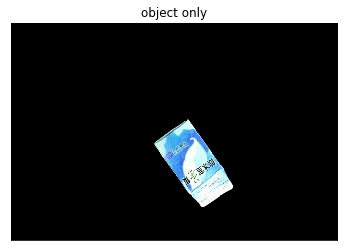

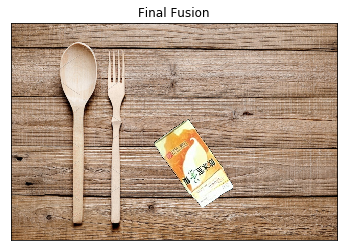

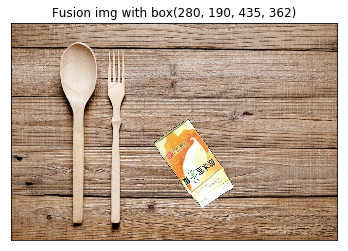

In [56]:
#test
#image_path = './DataSet_0129/img/Puff_0/Puff_1001_1.jpg'
#bg_img_path = './galaxy.jpg'
bg_img_path = './bg_database/table3.jpg'
image_path = './DataSet_0129/img/Oolong_Tea_0/Oolong_Tea_1001_1.jpg'
fusion, bounding_box = image_fusion(image_path, bg_img_path, save_img="", bg_resize=True,
                                    position_top_left=(280, 190) ,log_enable=True)
print("fusion img bounding box:", bounding_box)
plt.figure(), plt.imshow(cv2.cvtColor(fusion, cv2.COLOR_BGR2RGB)), plt.xticks([]), plt.yticks([])
plt.title('Fusion img with box'+str(bounding_box));